# Confidence Intervals for Time Series Forecasting

This notebook shows how to build confidence intervals for time series forecasts using residuals. I'll use the airline passengers dataset and a SARIMA model to walk through the approach.


## What are Confidence Intervals?

A confidence interval gives you a range around your forecast where the actual value is likely to fall. For a 99% confidence interval, you'd expect the true value to be inside that range about 99% of the time.

Why does this matter? Point forecasts alone don't tell you how uncertain you should be. Confidence intervals help with:
- Understanding how much uncertainty there is in your forecast
- Making better decisions when you need to account for risk
- Setting realistic bounds for planning
- Communicating forecast reliability

Basically, they tell you not just what you expect, but how confident you can be about it.


## How This Works

The idea is pretty straightforward - we look at how wrong our model has been in the past and use that to estimate uncertainty:

1. Train a model on historical data
2. Make forecasts for a backtest period (data we already have)
3. Calculate how far off we were: residual = actual - forecast
4. Find the standard deviation of those errors (σ)
5. Build intervals as: CI = forecast ± z × σ

The z-score depends on your confidence level (2.58 for 99%). 

One important assumption: the residuals should be normally distributed with mean zero. We'll check this later.


In [1]:
import warnings
warnings.filterwarnings('ignore')
# Suppress statsmodels convergence warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sktime.datasets import load_airline
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series


In [2]:
# Library versions for reproducibility
import matplotlib
import statsmodels
import sktime
import scipy

print("Library Versions:")
print("=" * 50)
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Matplotlib: {matplotlib.__version__}")
print(f"SciPy: {scipy.__version__}")
print(f"Statsmodels: {statsmodels.__version__}")
print(f"Sktime: {sktime.__version__}")
print("=" * 50)


Library Versions:
NumPy: 2.2.6
Pandas: 2.2.3
Matplotlib: 3.10.8
SciPy: 1.15.3
Statsmodels: 0.14.6
Sktime: 0.37.1


## Loading the Data

We use the classic airline passengers dataset, which contains monthly totals of international airline passengers from 1949 to 1960.


Dataset shape: (144,)
Date range: 1949-01 to 1960-12

First few values:
Period
1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
Freq: M, Name: Number of airline passengers, dtype: float64

Last few values:
Period
1960-08    606.0
1960-09    508.0
1960-10    461.0
1960-11    390.0
1960-12    432.0
Freq: M, Name: Number of airline passengers, dtype: float64


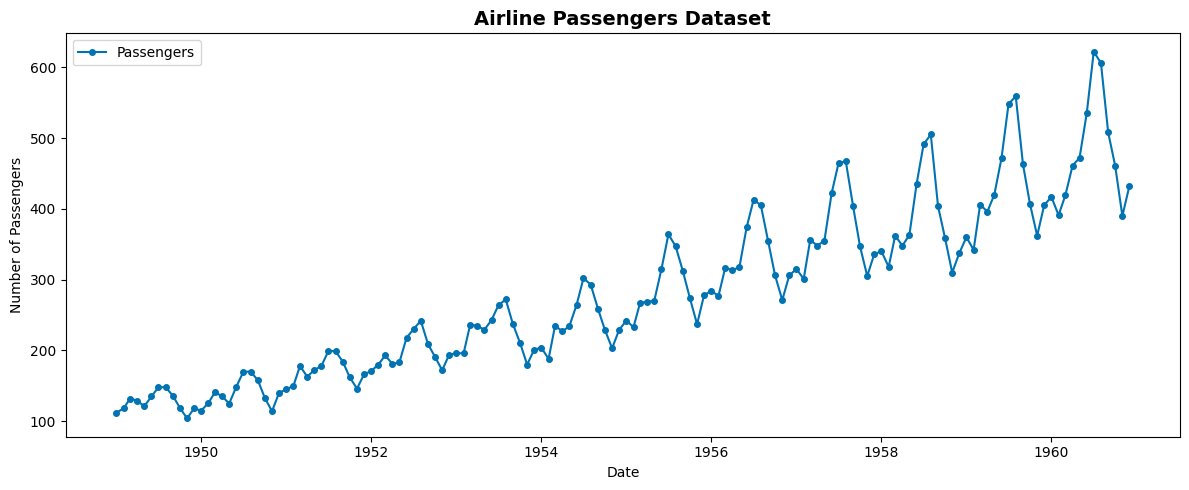

In [3]:
# Load the airline passengers dataset
y = load_airline()

print(f"Dataset shape: {y.shape}")
print(f"Date range: {y.index.min()} to {y.index.max()}")
print(f"\nFirst few values:")
print(y.head())
print(f"\nLast few values:")
print(y.tail())

# Plot the time series
fig, ax = plt.subplots(figsize=(12, 5))
plot_series(y, ax=ax, labels=["Passengers"])
ax.set_title("Airline Passengers Dataset", fontsize=14, fontweight='bold')
ax.set_xlabel("Date")
ax.set_ylabel("Number of Passengers")
plt.tight_layout()
plt.show()


## Splitting the Data

I'll split the data into training and test sets. The training set is for fitting the model and calculating residuals. The test set is for evaluating how well the confidence intervals work on unseen data.


Training set: 1949-01 to 1959-12 (132 months)
Test set: 1960-01 to 1960-12 (12 months)


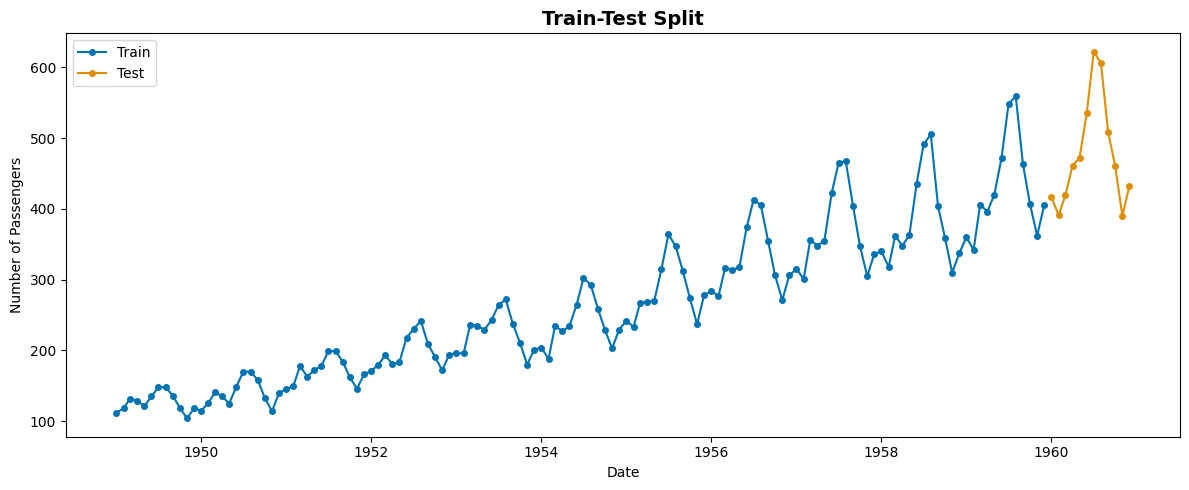

In [4]:
# Use last 12 months as test set
y_train, y_test = temporal_train_test_split(y, test_size=12)

print(f"Training set: {y_train.index.min()} to {y_train.index.max()} ({len(y_train)} months)")
print(f"Test set: {y_test.index.min()} to {y_test.index.max()} ({len(y_test)} months)")

# Plot train and test sets
fig, ax = plt.subplots(figsize=(12, 5))
plot_series(y_train, y_test, ax=ax, labels=["Train", "Test"])
ax.set_title("Train-Test Split", fontsize=14, fontweight='bold')
ax.set_xlabel("Date")
ax.set_ylabel("Number of Passengers")
plt.tight_layout()
plt.show()


## Training the Model

I'm using a SARIMA model to capture both trend and seasonality. The parameters (1,1,1)(1,1,1)12 mean it's a seasonal ARIMA with yearly seasonality (12 months).


In [5]:
# Train SARIMA model
# Converting to numpy array to avoid Period index issues
model = SARIMAX(y_train.values, order=(1, 1, 1), seasonal_order=(2, 1, 2, 12))
fitted_model = model.fit(disp=False)

print("Model trained")
print(f"AIC: {fitted_model.aic:.2f}")


Model trained
AIC: 899.91


## Calculating Residuals by Horizon

To get the standard deviation of residuals, I'll make forecasts on the training data and compare them to actual values. This shows how wrong the model has been historically. 

I'm calculating residuals for different horizons (1, 2, 3... steps ahead) because uncertainty typically increases the further out you forecast.


In [6]:
# Backtesting: use expanding window to simulate real forecasting
# Calculate residuals for different forecast horizons

min_train_size = 24
max_horizon = len(y_test)
residuals_by_horizon = {h: [] for h in range(1, max_horizon + 1)}

# For each time point, train on previous data and forecast ahead
for i in range(min_train_size, len(y_train)):
    y_train_window = y_train.iloc[:i]
    max_steps = min(max_horizon, len(y_train) - i)
    
    if max_steps < 1:
        continue
    
    try:
        model_window = SARIMAX(y_train_window.values, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
        fitted_model_window = model_window.fit(disp=False)
        y_pred_multi = fitted_model_window.forecast(steps=max_steps)
        
        # Calculate residuals for each horizon
        for h in range(1, max_steps + 1):
            if i + h - 1 < len(y_train):
                y_actual_h = float(y_train.iloc[i + h - 1])
                
                if isinstance(y_pred_multi, pd.Series):
                    y_pred_h = float(y_pred_multi.iloc[h - 1])
                else:
                    y_pred_h = float(np.asarray(y_pred_multi)[h - 1])
                
                residual = y_actual_h - y_pred_h
                residuals_by_horizon[h].append(residual)
    except Exception as e:
        print(f"Warning: Skipping iteration {i} due to error: {e}")
        continue

# Calculate sigma for each horizon
sigma_by_horizon = {}
for h in range(1, max_horizon + 1):
    if len(residuals_by_horizon[h]) > 0:
        sigma_by_horizon[h] = np.std(residuals_by_horizon[h])
    else:
        sigma_by_horizon[h] = np.nan

# Use horizon 1 residuals for overall analysis
residuals = np.array(residuals_by_horizon[1])
residuals_df = pd.DataFrame({'residual': residuals})

print(f"\nNumber of residuals by horizon:")
for h in range(1, max_horizon + 1):
    if len(residuals_by_horizon[h]) > 0:
        print(f"  Horizon {h}: {len(residuals_by_horizon[h])} residuals, σ = {sigma_by_horizon[h]:.2f}")

print(f"\nOverall Residual Statistics (Horizon 1):")
print(residuals_df['residual'].describe())
print(f"\nStandard deviation (σ) for horizon 1: {residuals_df['residual'].std():.2f}")



Number of residuals by horizon:
  Horizon 1: 108 residuals, σ = 11.17
  Horizon 2: 107 residuals, σ = 13.79
  Horizon 3: 106 residuals, σ = 16.95
  Horizon 4: 105 residuals, σ = 18.75
  Horizon 5: 104 residuals, σ = 19.80
  Horizon 6: 103 residuals, σ = 20.63
  Horizon 7: 102 residuals, σ = 21.58
  Horizon 8: 101 residuals, σ = 22.14
  Horizon 9: 100 residuals, σ = 22.14
  Horizon 10: 99 residuals, σ = 22.74
  Horizon 11: 98 residuals, σ = 22.47
  Horizon 12: 97 residuals, σ = 22.87

Overall Residual Statistics (Horizon 1):
count    108.000000
mean       0.604988
std       11.218004
min      -37.878218
25%       -7.175697
50%        0.105042
75%        8.085455
max       23.099689
Name: residual, dtype: float64

Standard deviation (σ) for horizon 1: 11.22


## Checking Residual Assumptions

For this approach to work well, residuals should be:
1. Normally distributed
2. Have zero mean (no bias)
3. Be independent (no autocorrelation)

Let's check if these hold.


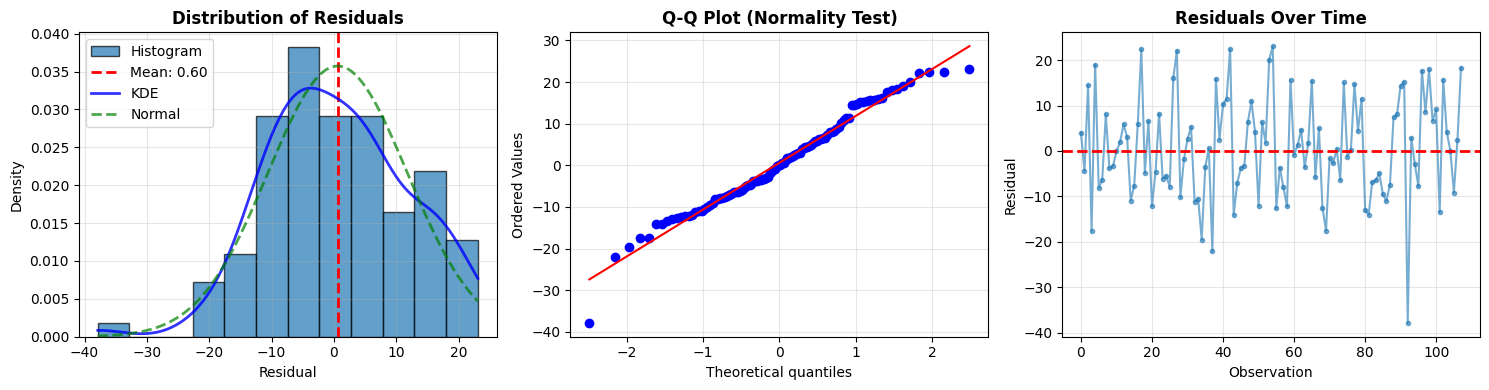

Statistical Tests:
Mean of residuals: 0.6050
Standard deviation: 11.1659

Shapiro-Wilk normality test:
  Statistic: 0.9799
  p-value: 0.1011
  Residuals appear to be normally distributed (p > 0.05)

Test for zero mean (using 95% confidence interval):
  Mean of residuals: 0.6050
  95% Confidence Interval: [-1.5250, 2.7349]
  Zero is within CI: True
  Mean is not significantly different from zero (CI contains zero)
  This is good for residual-based confidence intervals


In [7]:
# Plot 1: Histogram of residuals with KDE
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Histogram with fewer bins
n, bins, patches = axes[0].hist(residuals, bins=12, edgecolor='black', alpha=0.7, 
                                 density=True, label='Histogram')
axes[0].axvline(residuals.mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {residuals.mean():.2f}')

# Add Kernel Density Estimation (KDE)
from scipy.stats import gaussian_kde
kde = gaussian_kde(residuals)
x_kde = np.linspace(residuals.min(), residuals.max(), 200)
y_kde = kde(x_kde)
axes[0].plot(x_kde, y_kde, 'b-', linewidth=2, label='KDE', alpha=0.8)

# Add normal distribution for comparison
x_norm = np.linspace(residuals.min(), residuals.max(), 200)
y_norm = stats.norm.pdf(x_norm, residuals.mean(), residuals.std())
axes[0].plot(x_norm, y_norm, 'g--', linewidth=2, label='Normal', alpha=0.7)

axes[0].set_title('Distribution of Residuals', fontweight='bold')
axes[0].set_xlabel('Residual')
axes[0].set_ylabel('Density')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Q-Q plot for normality
stats.probplot(residuals, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot (Normality Test)', fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Residuals over time
axes[2].plot(residuals, marker='o', markersize=3, alpha=0.6)
axes[2].axhline(0, color='red', linestyle='--', linewidth=2)
axes[2].set_title('Residuals Over Time', fontweight='bold')
axes[2].set_xlabel('Observation')
axes[2].set_ylabel('Residual')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical tests
print("Statistical Tests:")
print(f"Mean of residuals: {residuals.mean():.4f}")
print(f"Standard deviation: {residuals.std():.4f}")

# Shapiro-Wilk test for normality
shapiro_stat, shapiro_p = stats.shapiro(residuals)
print(f"\nShapiro-Wilk normality test:")
print(f"  Statistic: {shapiro_stat:.4f}")
print(f"  p-value: {shapiro_p:.4f}")
if shapiro_p > 0.05:
    print("  Residuals appear to be normally distributed (p > 0.05)")
else:
    print("  Residuals may not be normally distributed (p <= 0.05)")

# Test for zero mean using confidence interval approach
# H0: mean is NOT zero (mean ≠ 0)
# If 95% CI contains zero, we cannot reject that mean = 0 (good for residuals)
# If 95% CI does NOT contain zero, mean is significantly different from zero (bad for residuals)
mean_residual = residuals.mean()
std_residual = residuals.std()
n = len(residuals)
se_mean = std_residual / np.sqrt(n)
t_critical = stats.t.ppf(0.975, df=n-1)  # 95% confidence level
ci_lower_mean = mean_residual - t_critical * se_mean
ci_upper_mean = mean_residual + t_critical * se_mean

print(f"\nTest for zero mean (using 95% confidence interval):")
print(f"  Mean of residuals: {mean_residual:.4f}")
print(f"  95% Confidence Interval: [{ci_lower_mean:.4f}, {ci_upper_mean:.4f}]")
print(f"  Zero is within CI: {ci_lower_mean <= 0 <= ci_upper_mean}")

if ci_lower_mean <= 0 <= ci_upper_mean:
    print("  Mean is not significantly different from zero (CI contains zero)")
    print("  This is good for residual-based confidence intervals")
else:
    print("  Mean is significantly different from zero (CI does not contain zero)")
    print("  This may indicate bias in the forecasts")


## Building Confidence Intervals

Now that we've checked the residuals look okay, we can use their standard deviation to build confidence intervals. Since uncertainty increases with horizon, I'll use different sigma values for each forecast step. Using 99% confidence level (z = 2.58).


Confidence level: 99.0%
Z-score: 2.58

Standard deviation (σ) by forecast horizon:
  Horizon 1: σ = 11.17
  Horizon 2: σ = 13.79
  Horizon 3: σ = 16.95
  Horizon 4: σ = 18.75
  Horizon 5: σ = 19.80
  Horizon 6: σ = 20.63
  Horizon 7: σ = 21.58
  Horizon 8: σ = 22.14
  Horizon 9: σ = 22.14
  Horizon 10: σ = 22.74
  Horizon 11: σ = 22.47
  Horizon 12: σ = 22.87

Confidence intervals constructed for 12 test observations

First few predictions with confidence intervals:
         actual    forecast    ci_lower    ci_upper
1960-01   417.0  421.794907  393.033331  450.556484
1960-02   391.0  403.390937  367.859408  438.922465
1960-03   419.0  465.164792  421.502180  508.827404
1960-04   461.0  453.063683  404.768915  501.358452
1960-05   472.0  479.187467  428.191576  530.183359


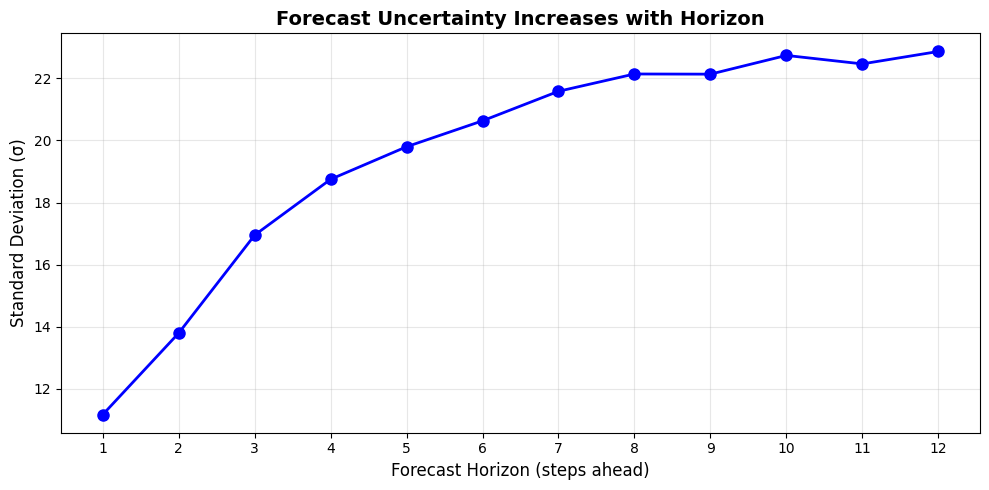

In [8]:
# Set confidence level and calculate z-score
confidence_level = 0.99
alpha = 1 - confidence_level
z_score = stats.norm.ppf(1 - alpha/2)

print(f"Confidence level: {confidence_level*100}%")
print(f"Z-score: {z_score:.2f}")

# Display sigma by horizon
print(f"\nStandard deviation (σ) by forecast horizon:")
for h in range(1, max_horizon + 1):
    if h in sigma_by_horizon and not np.isnan(sigma_by_horizon[h]):
        print(f"  Horizon {h}: σ = {sigma_by_horizon[h]:.2f}")

# Generate forecasts for test set
y_test_pred = fitted_model.forecast(steps=len(y_test))

# Convert to numpy arrays (handling Period index issues)
if isinstance(y_test_pred, pd.Series):
    y_test_pred_values = np.array(y_test_pred.values, dtype=float).flatten()
else:
    y_test_pred_values = np.array(y_test_pred, dtype=float).flatten()

y_test_actual_values = np.array(y_test.values, dtype=float).flatten()

# Build confidence intervals using sigma for each horizon
ci_lower = np.zeros(len(y_test_pred_values))
ci_upper = np.zeros(len(y_test_pred_values))

for h in range(1, len(y_test_pred_values) + 1):
    sigma_h = sigma_by_horizon.get(h, sigma_by_horizon.get(1, residuals.std()))
    if np.isnan(sigma_h):
        sigma_h = sigma_by_horizon.get(1, residuals.std())
    
    ci_lower[h - 1] = y_test_pred_values[h - 1] - z_score * sigma_h
    ci_upper[h - 1] = y_test_pred_values[h - 1] + z_score * sigma_h

# Create results DataFrame
results_df = pd.DataFrame({
    'actual': y_test_actual_values,
    'forecast': y_test_pred_values,
    'ci_lower': ci_lower,
    'ci_upper': ci_upper
}, index=y_test.index)

print(f"\nConfidence intervals constructed for {len(results_df)} test observations")
print(f"\nFirst few predictions with confidence intervals:")
print(results_df.head())

# Visualize how sigma varies with horizon
fig, ax = plt.subplots(figsize=(10, 5))
horizons = [h for h in range(1, max_horizon + 1) if h in sigma_by_horizon and not np.isnan(sigma_by_horizon[h])]
sigmas = [sigma_by_horizon[h] for h in horizons]
ax.plot(horizons, sigmas, marker='o', linewidth=2, markersize=8, color='blue')
ax.set_xlabel('Forecast Horizon (steps ahead)', fontsize=12)
ax.set_ylabel('Standard Deviation (σ)', fontsize=12)
ax.set_title('Forecast Uncertainty Increases with Horizon', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_xticks(horizons)
plt.tight_layout()
plt.show()


## Visualizing the Results

Here's how the forecasts and confidence intervals look compared to actual values.


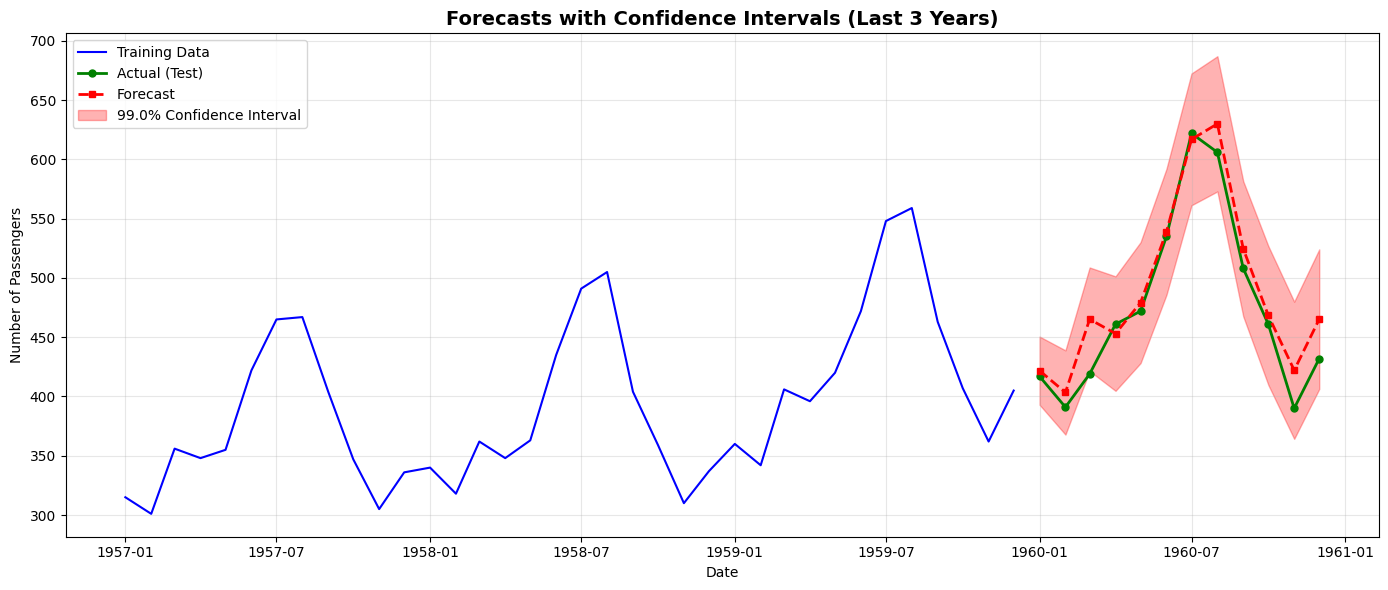

In [9]:
# Plot showing last 3 years for better visualization
fig, ax = plt.subplots(figsize=(14, 6))

years_to_show = 3
months_to_show = years_to_show * 12
y_train_plot = y_train.iloc[-months_to_show:] if len(y_train) >= months_to_show else y_train

# Convert Period index to datetime
y_train_index = pd.to_datetime([str(p) for p in y_train_plot.index])
ax.plot(y_train_index, y_train_plot.values, label='Training Data', color='blue', linewidth=1.5)

y_test_index = pd.to_datetime([str(p) for p in y_test.index])
ax.plot(y_test_index, y_test.values, label='Actual (Test)', color='green', 
        marker='o', markersize=5, linewidth=2)

ax.plot(y_test_index, y_test_pred_values, label='Forecast', color='red', 
        linestyle='--', marker='s', markersize=5, linewidth=2)

ax.fill_between(y_test_index, ci_lower, ci_upper, alpha=0.3, color='red', 
                label=f'{confidence_level*100}% Confidence Interval')

ax.set_title('Forecasts with Confidence Intervals (Last 3 Years)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Passengers')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Evaluating the Intervals

I'll use two metrics to evaluate how good these confidence intervals are:

1. **Coverage Rate**: What percentage of actual values fall inside the interval. For 99% confidence, we'd expect about 99% coverage.

2. **Winkler Score**: Penalizes both wide intervals and points outside the interval. Lower is better.


In [10]:
def calculate_winkler_score(y_true, ci_lower, ci_upper, alpha):
    """
    Calculate Winkler Score for prediction intervals.
    
    The Winkler Score penalizes:
    - Wide intervals (larger interval length)
    - Observations outside the interval (with penalty proportional to distance)
    
    Lower scores indicate better interval forecasts.
    
    Parameters:
    -----------
    y_true : array-like
        Actual observed values
    ci_lower : array-like
        Lower bound of confidence interval
    ci_upper : array-like
        Upper bound of confidence interval
    alpha : float
        Significance level (e.g., 0.01 for 99% confidence)
    
    Returns:
    --------
    array-like
        Winkler Score for each observation
    """
    y_true = np.array(y_true)
    ci_lower = np.array(ci_lower)
    ci_upper = np.array(ci_upper)
    
    # Interval length
    interval_length = ci_upper - ci_lower
    
    # Calculate penalty based on position of y_true
    penalty = np.zeros_like(y_true)
    
    # If y_true < ci_lower
    mask_below = y_true < ci_lower
    penalty[mask_below] = (2 / alpha) * (ci_lower[mask_below] - y_true[mask_below])
    
    # If y_true > ci_upper
    mask_above = y_true > ci_upper
    penalty[mask_above] = (2 / alpha) * (y_true[mask_above] - ci_upper[mask_above])
    
    # Winkler Score = interval length + penalty
    winkler_score = interval_length + penalty
    
    return winkler_score


In [11]:
# Calculate coverage rate
results_df['within_ci'] = (results_df['actual'] >= results_df['ci_lower']) & \
                          (results_df['actual'] <= results_df['ci_upper'])
coverage_rate = results_df['within_ci'].mean() * 100

print(f"Coverage Rate: {coverage_rate:.2f}%")
print(f"Expected coverage: {confidence_level*100}%")
print(f"Difference: {coverage_rate - confidence_level*100:.2f} percentage points")

# Calculate Winkler Score
results_df['winkler_score'] = calculate_winkler_score(
    results_df['actual'],
    results_df['ci_lower'],
    results_df['ci_upper'],
    alpha
)

mean_winkler = results_df['winkler_score'].mean()
print(f"\nMean Winkler Score: {mean_winkler:.2f}")

# Additional statistics
print(f"\nDetailed Statistics:")
print(f"  Observations within CI: {results_df['within_ci'].sum()} / {len(results_df)}")
print(f"  Observations outside CI: {(~results_df['within_ci']).sum()} / {len(results_df)}")
print(f"  Mean interval width: {(results_df['ci_upper'] - results_df['ci_lower']).mean():.2f}")
print(f"  Mean absolute error: {np.abs(results_df['actual'] - results_df['forecast']).mean():.2f}")


Coverage Rate: 91.67%
Expected coverage: 99.0%
Difference: -7.33 percentage points

Mean Winkler Score: 142.60

Detailed Statistics:
  Observations within CI: 11 / 12
  Observations outside CI: 1 / 12
  Mean interval width: 100.90
  Mean absolute error: 16.73


## Coverage Visualization

Here's which points fall inside the interval and which don't.


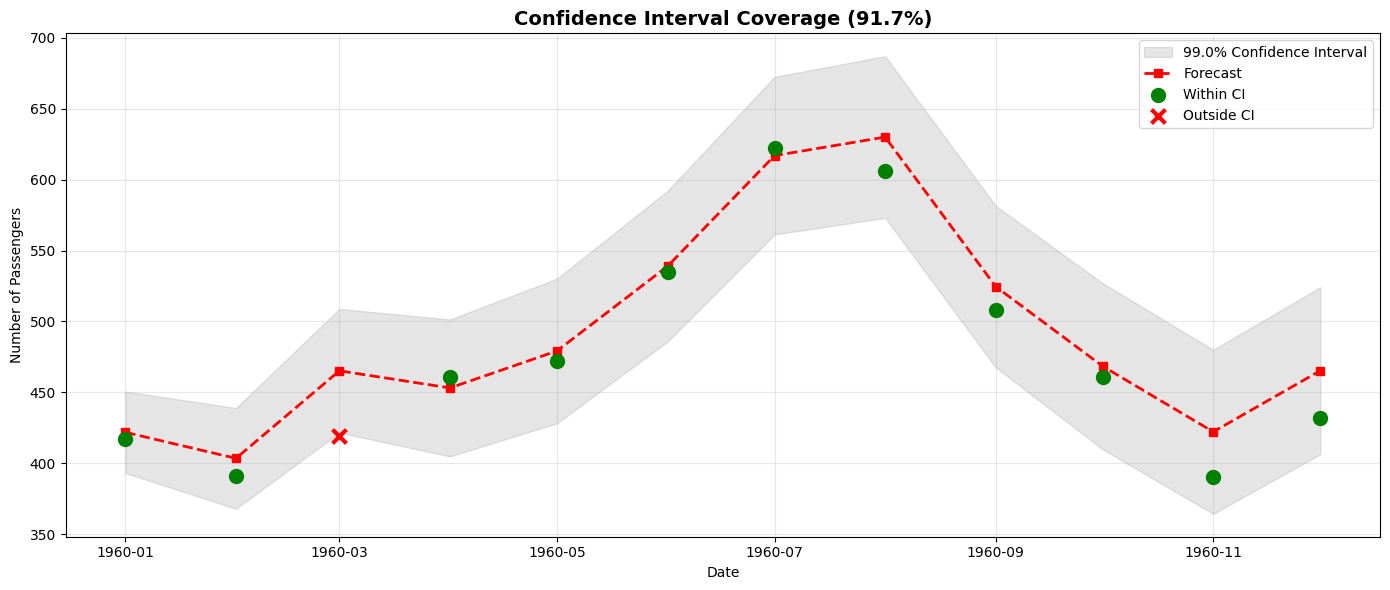

In [12]:
# Coverage visualization
fig, ax = plt.subplots(figsize=(14, 6))

results_index = pd.to_datetime([str(p) for p in results_df.index])

# Plot confidence intervals
ax.fill_between(results_index, results_df['ci_lower'], results_df['ci_upper'], 
                alpha=0.2, color='gray', label=f'{confidence_level*100}% Confidence Interval')

# Plot forecasts
ax.plot(results_index, results_df['forecast'], 'r--', marker='s', 
        markersize=6, linewidth=2, label='Forecast')

# Plot actual values, color-coded by whether they're within CI
within_mask = results_df['within_ci']
ax.scatter(results_index[within_mask], results_df['actual'][within_mask], 
          color='green', s=100, marker='o', zorder=5, label='Within CI')
ax.scatter(results_index[~within_mask], results_df['actual'][~within_mask], 
          color='red', s=100, marker='x', linewidths=3, zorder=5, label='Outside CI')

ax.set_title(f'Confidence Interval Coverage ({coverage_rate:.1f}%)', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Passengers')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Note on the observation outside the confidence interval:**

March typically shows a peak in passenger numbers due to seasonal patterns in the airline industry. However, in 1960, this expected peak did not occur, representing an exceptional anomaly that was very difficult to predict. This explains why we have one point outside the confidence interval (March 1960), despite being very close to the lower bound. Such anomalies highlight the importance of confidence intervals in capturing forecast uncertainty, as they help identify periods where actual values deviate from expected patterns.


## Summary

Here's a summary of the key metrics.


In [13]:
# Calculate average sigma for summary
sigma_avg = np.mean([s for s in sigma_by_horizon.values() if not np.isnan(s)])
sigma_horizon1 = sigma_by_horizon.get(1, residuals.std())

# Create summary table
summary = pd.DataFrame({
    'Metric': [
        'Confidence Level',
        'Standard Deviation (σ) - Horizon 1',
        'Standard Deviation (σ) - Average',
        'Z-Score',
        'Coverage Rate',
        'Expected Coverage',
        'Mean Winkler Score',
        'Mean Interval Width',
        'Mean Absolute Error (MAE)',
        'Root Mean Squared Error (RMSE)'
    ],
    'Value': [
        f'{confidence_level*100}%',
        f'{sigma_horizon1:.2f}',
        f'{sigma_avg:.2f}',
        f'{z_score:.2f}',
        f'{coverage_rate:.2f}%',
        f'{confidence_level*100}%',
        f'{mean_winkler:.2f}',
        f'{(results_df["ci_upper"] - results_df["ci_lower"]).mean():.2f}',
        f'{np.abs(results_df["actual"] - results_df["forecast"]).mean():.2f}',
        f'{np.sqrt(((results_df["actual"] - results_df["forecast"])**2).mean()):.2f}'
    ]
})

print("=" * 60)
print("SUMMARY OF RESULTS")
print("=" * 60)
print(summary.to_string(index=False))
print("=" * 60)


SUMMARY OF RESULTS
                            Metric  Value
                  Confidence Level  99.0%
Standard Deviation (σ) - Horizon 1  11.17
  Standard Deviation (σ) - Average  19.59
                           Z-Score   2.58
                     Coverage Rate 91.67%
                 Expected Coverage  99.0%
                Mean Winkler Score 142.60
               Mean Interval Width 100.90
         Mean Absolute Error (MAE)  16.73
    Root Mean Squared Error (RMSE)  21.42


## Takeaways

1. **Residual-based confidence intervals** are a simple way to quantify forecast uncertainty using past errors.

2. **Check your assumptions**: The method assumes residuals are normally distributed with zero mean. Always verify this before using it.

3. **Coverage rate** should match your confidence level. Too low means intervals are too narrow, too high means they're unnecessarily wide.

4. **Winkler Score** balances interval width with coverage. Lower is better.

5. **Using different sigmas by horizon** accounts for the fact that uncertainty increases the further out you forecast.

This approach works well when:
- You need uncertainty estimates for decision-making
- Your model doesn't provide built-in confidence intervals
- You want to validate intervals using historical performance
